In [1]:
import lightning as L
import os
import matplotlib.pyplot as plt
import numpy as np
import torch
from models.DAE_amass import LitDAE
from torch.utils.data import DataLoader
from pytorch_lightning.loggers import TensorBoardLogger

In [2]:
# Data from all files
root_dir = "data"

# Traverse through all files to load .pt files
# Check the shape of all downloaded data until now
dataset = []
for filename in os.listdir(root_dir):
    file_path = os.path.join(root_dir, filename)
    loaded_tensor = torch.load(file_path)
    dataset.append(loaded_tensor)

dataset = torch.cat(dataset)
print(dataset.shape)

# Convert the list of numpy arrays to a single tensor
# Adjust the stacking or reshaping based on your data (e.g., [num_samples, sequence_length, features])
shuffled_indices = torch.randperm(dataset.shape[0])
train_ratio = 0.9
train_size = int(train_ratio * dataset.shape[0])

train_tensor = dataset[shuffled_indices[:train_size]]
val_tensor = dataset[shuffled_indices[train_size:]]
print(train_tensor.shape)
print(val_tensor.shape)

# Create a DataLoader directly from the tensor
batch_size = 8
train_loader = DataLoader(train_tensor, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(val_tensor, batch_size=batch_size, shuffle=True)

torch.Size([4, 50, 24, 3])
torch.Size([3, 50, 24, 3])
torch.Size([1, 50, 24, 3])


C:\Users\jeanv\AppData\Local\Temp\ipykernel_5816\1063969743.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_tensor = torch.load(file_path)


torch.Size([50, 24, 3])


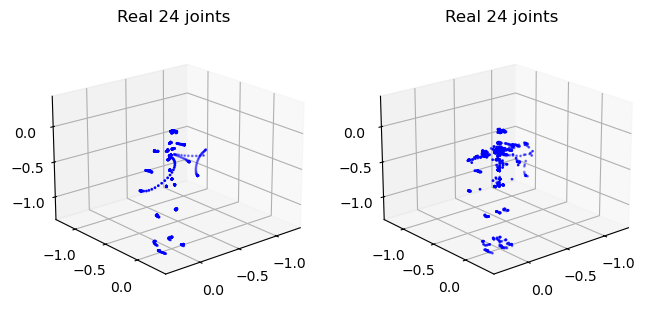

In [3]:
# Print a ground truth example

real_joints24 = train_tensor[0]

# Print a masked example

masked = train_tensor[0].clone()
mask = (torch.rand_like(masked) > 0.3).float()
masked = masked * mask
print(masked.shape)

fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(131, projection='3d')
ax2 = fig.add_subplot(132, projection='3d')


ax1.scatter(real_joints24[:,:,0], real_joints24[:,:,2], real_joints24[:,:,1], c='b', marker='o', s=1)
ax1.set_title("Real 24 joints")
val_min = real_joints24.min()
val_max = real_joints24.max()
ax1.set_xlim(val_min, val_max)
ax1.set_ylim(val_min, val_max)
ax1.set_zlim(val_min, val_max)
ax1.view_init(elev=20, azim=50)

ax2.scatter(masked[:,:,0], masked[:,:,2], masked[:,:,1], c='b', marker='o', s=1)
ax2.set_title("Real 24 joints")
val_min = real_joints24.min()
val_max = real_joints24.max()
ax2.set_xlim(val_min, val_max)
ax2.set_ylim(val_min, val_max)
ax2.set_zlim(val_min, val_max)
ax2.view_init(elev=20, azim=50)

In [4]:
logger = TensorBoardLogger("./tensorboard")

# According to Zhe Li (2023), the best performances are achieved with a missing ratio of 0.75

DAE = LitDAE(time_length=50,
             nb_joints=24,
             latent_dim=20,
             missing_ratio=0.3,
             lr=1e-3,
             batchsize=8,
             epochs=0)
trainer = L.Trainer(logger=logger, max_epochs=0)
trainer.fit(model=DAE, train_dataloaders=train_loader, val_dataloaders=valid_loader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name    | Type      | Params | Mode 
----------------------------------------------
0 | encoder | Encoder   | 25.8 K | train
1 | decoder | Decoder   | 1.6 K  | train
2 | ln      | LayerNorm | 40     | train
3 | gru     | GRU       | 2.5 K  | train
----------------------------------------------
29.9 K    Trainable params
0         Non-trainable params
29.9 K    Total params
0.120     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

d:\Apps\Anaconda\envs\crossing_venv\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:475: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
d:\Apps\Anaconda\envs\crossing_venv\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
d:\Apps\Anaconda\envs\crossing_venv\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
d:\Apps\Anaconda\envs\crossing_venv\Lib\site-packages\lightning\pytorch\loops\fit_loop.py:298: The number of training batc

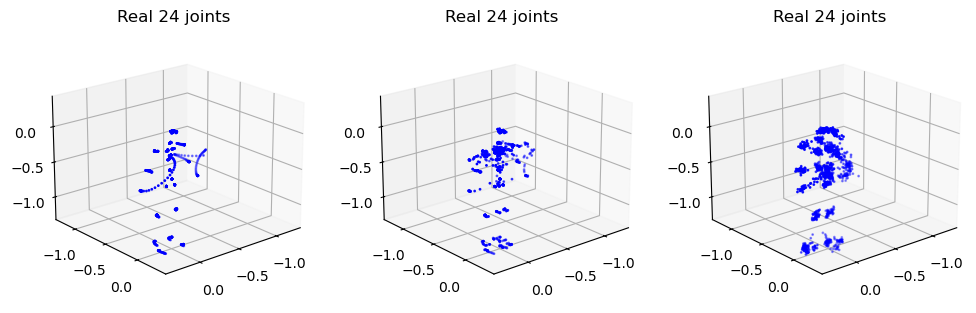

In [8]:
# load checkpoint
checkpoint = "./tensorboard/lightning_logs/version_1/checkpoints/epoch=499-step=500.ckpt"
model = LitDAE
model = model.load_from_checkpoint(checkpoint)
model.eval()

# Print a ground truth example

real_joints24 = train_tensor[0]

# Print a masked example

masked = train_tensor[0].clone()
mask = (torch.rand_like(masked) > 0.3).float()
masked = masked * mask

# Get the reconstructed data

masked = masked.unsqueeze(0)
reconstructed_joints = model(masked)
reconstructed_joints = reconstructed_joints.detach().squeeze()
masked = masked.squeeze()

# Plots

fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(131, projection='3d')
ax2 = fig.add_subplot(132, projection='3d')
ax3 = fig.add_subplot(133, projection='3d')


ax1.scatter(real_joints24[:,:,0], real_joints24[:,:,2], real_joints24[:,:,1], c='b', marker='o', s=1)
ax1.set_title("Real 24 joints")
val_min = real_joints24.min()
val_max = real_joints24.max()
ax1.set_xlim(val_min, val_max)
ax1.set_ylim(val_min, val_max)
ax1.set_zlim(val_min, val_max)
ax1.view_init(elev=20, azim=50)

ax2.scatter(masked[:,:,0], masked[:,:,2], masked[:,:,1], c='b', marker='o', s=1)
ax2.set_title("Real 24 joints")
val_min = real_joints24.min()
val_max = real_joints24.max()
ax2.set_xlim(val_min, val_max)
ax2.set_ylim(val_min, val_max)
ax2.set_zlim(val_min, val_max)
ax2.view_init(elev=20, azim=50)

ax3.scatter(reconstructed_joints[:,:,0], reconstructed_joints[:,:,2], reconstructed_joints[:,:,1], c='b', marker='o', s=1)
ax3.set_title("Real 24 joints")
val_min = real_joints24.min()
val_max = real_joints24.max()
ax3.set_xlim(val_min, val_max)
ax3.set_ylim(val_min, val_max)
ax3.set_zlim(val_min, val_max)
ax3.view_init(elev=20, azim=50)
